# DMD for SET Data(Improved)
## Correcting the reversed scores

Date: 07/10/2019

## Creating Dataset for DMD

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD

In [4]:
from sys import maxsize
from numpy import set_printoptions

In [5]:
## Import data set

df = pd.read_csv('SET data archive 3416 cases recd thru end of 03 2019_cleaned_general.csv')
df.head()

,Unnamed: 0,UniqueID,no_intake_question,no_retest1_question,no_retest2_question,SET_program_num,ETO_PROGRAM,SET_admin_num,baseline_type,enroll_SET_type_num,...,Completed_by_CIW,CIW_CLIENT_ID,CIW_INTERVIEW_DATE,CIW_COMPLETED_DATE,CIW1,CIW2,CIW3,CIW4,CIW5,CIW6_COMMENTS
0,3,49866,,,,1,1,1,,,...,999,,,,1.0,4.0,4.0,1.0,3.0,Client's son is helping him to change little b...
1,4,49868,,,,1,1,1,,,...,999,,,,2.0,3.0,4.0,1.0,3.0,Slow progress
2,5,49870,,,,1,1,1,,,...,999,,,,2.0,3.0,3.0,1.0,3.0,She goes there a lot ?home? She is trying to c...
3,8,47002,,,,1,1,1,,,...,999,Southwest 2-23-230-1,9/13/2018,9/13/2018,2.0,3.0,1.0,4.0,0.0,Client has been attending program and is stayi...
4,13,41570,,,,2,2,1,,1,...,999,SSSEARE-0-100-1,,,NaN,NaN,NaN,NaN,NaN,no page 17 completed


In [6]:
df['S10'].value_counts()

0.0    1077
1.0     681
2.0     492
3.0     289
4.0     120
5.0      49
6.0      23
7.0      19
Name: S10, dtype: int64

### List all columns needed for DMD dataset

In [7]:
col_kept = ['UniqueID']
col_kept.extend(df.loc[:,'intake':'retest'].columns.tolist())
col_kept.extend(df.loc[:,'GRYD_Zone_num':'INTERVIEW_DATE_FB'].columns.tolist())
col_kept.extend(df.loc[:,'ENROLLMENT_DATE_1':'SEX_1'].columns.tolist())

In [8]:
#include questions only before family

# S section
# attitudinal and score correctly
que = df.loc[:,'S9':'S10'].columns.tolist()
que.extend(df.loc[:,'S10x':'S11a'].columns.tolist())
que.extend(df.loc[:,'S11b':'S16'].columns.tolist())

# ME,P,C section
# except ME18 all reversed 
que.extend(df.loc[:,'ME17':'ME22_ER'].columns.tolist())

# P22,p23,p26 are not scaled correctly
que.extend(df.loc[:,'P22':'P26'].columns.tolist())
que.extend(df.loc[:,'X18':'X22'].columns.tolist())

In [9]:
print(que)
len(que)

['S9', 'S10', 'S10x', 'S10z', 'S11a', 'S11b', 'S12', 'S13', 'S14', 'S16', 'ME17', 'ME18', 'ME19', 'ME20a', 'ME20b', 'ME20x', 'ME22_ER', 'P22', 'P23', 'P24', 'P25', 'P26', 'X18', 'X19', 'X20', 'X21', 'X22']


27

In [10]:
# create the dataframe for DMD

col_kept.extend(que)
df_que = df.filter(col_kept, axis=1)
df_que.head(40)

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
0,49866,1,777,14,3/15/2019,3/6/2019,22,1,3.0,0.0,...,4.0,4.0,2.0,2.0,5.0,1.0,0.0,1.0,1.0,1.0
1,49868,1,777,14,3/15/2019,3/7/2019,23,1,3.0,0.0,...,4.0,4.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0
2,49870,1,777,14,3/14/2019,3/6/2019,25,2,3.0,0.0,...,5.0,5.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0
3,47002,1,777,23,9/13/2018,9/4/2018,18,2,0.0,0.0,...,3.0,3.0,3.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0
4,41570,1,777,999,10/25/2017,10/6/2017,16,1,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,1.0,0.0,1.0,1.0,0.0
5,42392,1,777,999,1/16/2018,1/8/2018,16,1,2.0,0.0,...,4.0,4.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0
6,43298,1,777,999,5/1/2018,3/14/2018,15,1,4.0,0.0,...,5.0,5.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0
7,45090,1,777,999,5/31/2018,5/22/2018,15,2,3.0,0.0,...,4.0,4.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0
8,26789,1,777,999,4/15/2016,8/13/2015,17,1,4.0,1.0,...,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0.0,1.0
9,35390,1,777,999,7/17/2017,10/14/2016,18,1,4.0,0.0,...,4.0,4.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0


## Create dataframe for ID3

In [11]:
df_que['retest'].value_counts()

777    2009
1       643
2       101
3        15
999       1
Name: retest, dtype: int64

In [12]:
# list all people whose ID appear three times

ID_3 = df_que.UniqueID.value_counts()[df_que.UniqueID.value_counts() == 3].index
len(ID_3)

60

In [13]:
df_ID3 = df_que[df_que['UniqueID'].isin(ID_3)]

In [14]:
df_ID3.head()

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
78,35341,777,1,1,3/9/2017,9/27/2016,16,2,2.0,2.0,...,4.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0
79,35341,1,777,1,9/27/2016,9/27/2016,16,2,2.0,2.0,...,4.0,3.0,3.0,3.0,3.0,1.0,0.0,1.0,1.0,1.0
80,35341,777,2,1,10/26/2017,9/27/2016,18,2,2.0,0.0,...,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0
452,36470,1,777,5,11/7/2016,11/7/2016,18,1,5.0,4.0,...,5.0,5.0,2.0,1.0,5.0,1.0,0.0,1.0,0.0,0.0
453,36470,777,1,5,4/19/2017,10/31/2016,18,1,5.0,3.0,...,5.0,5.0,2.0,2.0,5.0,1.0,0.0,1.0,0.0,0.0


In [15]:
#sort the dataset according to the interview date group by UniqueID

df_ID3['INTERVIEW_DATE_FB'] = pd.to_datetime(df_ID3['INTERVIEW_DATE_FB'], errors='coerce')
df_ID3 = df_ID3.sort_values(by = ['UniqueID','INTERVIEW_DATE_FB'],ascending=True)
df_ID3.head()

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1252,28923,1,777,10,2015-11-06,10/29/2015,18,1,3.0,1.0,...,4.0,4.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0
1253,28923,777,1,10,2016-05-10,10/29/2015,19,1,3.0,1.0,...,4.0,4.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,1.0
1251,28923,777,2,10,2017-04-27,10/29/2015,20,1,3.0,0.0,...,5.0,5.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
1436,30669,1,777,12,2016-04-11,3/4/2016,15,2,3.0,3.0,...,4.0,5.0,1.0,2.0,4.0,1.0,0.0,1.0,1.0,1.0
1434,30669,777,1,12,2016-09-06,3/4/2016,15,2,3.0,2.0,...,4.0,4.0,3.0,4.0,4.0,1.0,0.0,1.0,1.0,1.0


In [16]:
# drop the person who does not take intake but take three retests instead 

df_ID3 = df_ID3[df_ID3['UniqueID'] != 39880]

### Take care of the people who have nan values in their reponses

In [17]:
#check how many nan values are there in each column

print(df_ID3[que].isnull().sum())

S9         1
S10        1
S10x       2
S10z       2
S11a       1
S11b       2
S12        0
S13        0
S14        0
S16        0
ME17       0
ME18       0
ME19       0
ME20a      0
ME20b      0
ME20x      0
ME22_ER    0
P22        0
P23        0
P24        0
P25        0
P26        0
X18        1
X19        1
X20        1
X21        1
X22        2
dtype: int64


In [18]:
#list the index for those have null values 

List_index=[]
for col in que:
    List_index.extend(df_ID3[df_ID3[col].isnull()].index.tolist())
List_index

[923,
 923,
 1252,
 923,
 1252,
 923,
 923,
 923,
 2468,
 2107,
 2107,
 2107,
 2107,
 2107,
 1728]

In [19]:
#create a unique list for index list

my_set = set(List_index)
unique_index_list = list(my_set)
unique_index_list

[1728, 2468, 923, 1252, 2107]

In [20]:
#create unique ID_list

ID_list = []
for i in unique_index_list:
        ID_list.append(df_ID3.loc[i,'UniqueID'])
ID_list

[39228, 43237, 41793, 28923, 38198]

In [21]:
#drop these people who have nan values 

for ID in ID_list:
    df_ID3 = df_ID3[df_ID3['UniqueID'] != ID]
df_ID3.shape

(162, 35)

## Correcting Scores

#### Majority of questions are in the case that the higher the scores are, the risky they are 
  #### Except for the ME18, ME20x, P24, P25

In [22]:
# ME18

df_ID3['new'] = 0

Score_1 = df_ID3[df_ID3['ME18'] == 1].index.tolist()
Score_2 = df_ID3[df_ID3['ME18'] == 2].index.tolist()
Score_3 = df_ID3[df_ID3['ME18'] == 3].index.tolist()
Score_4 = df_ID3[df_ID3['ME18'] == 4].index.tolist()
Score_5 = df_ID3[df_ID3['ME18'] == 5].index.tolist()
for index in Score_1:
    df_ID3.loc[index,'new'] = 5
for index in Score_2:
    df_ID3.loc[index,'new'] = 4
for index in Score_3:
    df_ID3.loc[index,'new'] = 3
for index in Score_4:
    df_ID3.loc[index,'new'] = 2
for index in Score_5:
    df_ID3.loc[index,'new'] = 1

df_ID3['ME18'] = df_ID3['new']

In [23]:
df_ID3['ME18'].value_counts()

2    67
3    47
1    28
4    17
5     3
Name: ME18, dtype: int64

In [24]:
# ME20x

df_ID3['new'] = 0

Score_1 = df_ID3[df_ID3['ME20x'] == 1].index.tolist()
Score_2 = df_ID3[df_ID3['ME20x'] == 2].index.tolist()
Score_3 = df_ID3[df_ID3['ME20x'] == 3].index.tolist()
Score_4 = df_ID3[df_ID3['ME20x'] == 4].index.tolist()
Score_5 = df_ID3[df_ID3['ME20x'] == 5].index.tolist()
for index in Score_1:
    df_ID3.loc[index,'new'] = 5
for index in Score_2:
    df_ID3.loc[index,'new'] = 4
for index in Score_3:
    df_ID3.loc[index,'new'] = 3
for index in Score_4:
    df_ID3.loc[index,'new'] = 2
for index in Score_5:
    df_ID3.loc[index,'new'] = 1

df_ID3['ME20x'] = df_ID3['new']

In [25]:
df_ID3['ME20x'].value_counts()

2    80
3    31
1    30
4    14
5     7
Name: ME20x, dtype: int64

In [26]:
# P24

df_ID3['new'] = 0

Score_1 = df_ID3[df_ID3['P24'] == 1].index.tolist()
Score_2 = df_ID3[df_ID3['P24'] == 2].index.tolist()
Score_3 = df_ID3[df_ID3['P24'] == 3].index.tolist()
Score_4 = df_ID3[df_ID3['P24'] == 4].index.tolist()
Score_5 = df_ID3[df_ID3['P24'] == 5].index.tolist()
for index in Score_1:
    df_ID3.loc[index,'new'] = 5
for index in Score_2:
    df_ID3.loc[index,'new'] = 4
for index in Score_3:
    df_ID3.loc[index,'new'] = 3
for index in Score_4:
    df_ID3.loc[index,'new'] = 2
for index in Score_5:
    df_ID3.loc[index,'new'] = 1

df_ID3['P24'] = df_ID3['new']

In [27]:
df_ID3['P24'].value_counts()

3    61
4    40
1    26
5    19
2    16
Name: P24, dtype: int64

In [28]:
# P25

df_ID3['new'] = 0

Score_1 = df_ID3[df_ID3['P25'] == 1].index.tolist()
Score_2 = df_ID3[df_ID3['P25'] == 2].index.tolist()
Score_3 = df_ID3[df_ID3['P25'] == 3].index.tolist()
Score_4 = df_ID3[df_ID3['P25'] == 4].index.tolist()
Score_5 = df_ID3[df_ID3['P25'] == 5].index.tolist()
for index in Score_1:
    df_ID3.loc[index,'new'] = 5
for index in Score_2:
    df_ID3.loc[index,'new'] = 4
for index in Score_3:
    df_ID3.loc[index,'new'] = 3
for index in Score_4:
    df_ID3.loc[index,'new'] = 2
for index in Score_5:
    df_ID3.loc[index,'new'] = 1

df_ID3['P25'] = df_ID3['new']

In [29]:
df_ID3['P25'].value_counts()

3    48
2    37
4    30
1    25
5    22
Name: P25, dtype: int64

## Create Y1, R1, R2 matrices

In [30]:
# create Y1 matrix 

Y1 = df_ID3[df_ID3['intake'] == 1]
Y1.head()
Y1_MATRIX = Y1[que]
Y1_MATRIX.head(10)

,S9,S10,S10x,S10z,S11a,S11b,S12,S13,S14,S16,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1436,3.0,3.0,0.0,0.0,0.0,0.0,4.0,5.0,5.0,4.0,...,4.0,5.0,5,4,4.0,1.0,0.0,1.0,1.0,1.0
2364,1.0,1.0,1.0,1.0,1.0,0.0,4.0,4.0,4.0,4.0,...,3.0,4.0,5,4,5.0,1.0,1.0,1.0,1.0,1.0
2337,2.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,3.0,4.0,...,5.0,5.0,5,4,5.0,1.0,0.0,1.0,1.0,0.0
2299,7.0,4.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,3.0,...,3.0,3.0,4,4,3.0,1.0,1.0,0.0,1.0,0.0
1041,5.0,3.0,1.0,0.0,1.0,0.0,4.0,4.0,5.0,3.0,...,5.0,5.0,4,3,5.0,1.0,0.0,1.0,1.0,1.0
1035,2.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,4.0,2.0,...,5.0,5.0,4,4,4.0,1.0,1.0,1.0,0.0,0.0
2116,3.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,2.0,3.0,...,4.0,4.0,1,2,3.0,1.0,1.0,1.0,1.0,1.0
2119,3.0,1.0,1.0,0.0,0.0,0.0,2.0,3.0,3.0,4.0,...,5.0,4.0,3,2,2.0,1.0,0.0,1.0,1.0,1.0
1483,4.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,4.0,1.0,...,2.0,2.0,1,2,2.0,1.0,1.0,1.0,0.0,1.0
2129,3.0,2.0,1.0,1.0,0.0,0.0,3.0,4.0,4.0,3.0,...,4.0,5.0,3,1,3.0,1.0,1.0,0.0,0.0,0.0


In [31]:
#create R1 matrxi

R1 = df_ID3[df_ID3['retest'] == 1]
R1.head()
R1_MATRIX = R1[que]
R1_MATRIX.head()

,S9,S10,S10x,S10z,S11a,S11b,S12,S13,S14,S16,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1434,3.0,2.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,5.0,...,4.0,4.0,3,2,4.0,1.0,0.0,1.0,1.0,1.0
2363,1.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,3.0,4.0,...,3.0,2.0,4,3,3.0,1.0,1.0,1.0,1.0,1.0
2336,2.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,2.0,2.0,...,5.0,5.0,4,3,4.0,1.0,1.0,1.0,1.0,1.0
2300,2.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,3.0,...,3.0,4.0,5,5,4.0,1.0,1.0,1.0,1.0,1.0
1039,7.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,...,4.0,5.0,4,4,4.0,1.0,0.0,1.0,1.0,0.0


In [32]:
#create R2 matrix

R2 = df_ID3[df_ID3['retest'] == 2]
R2.head()
R2_MATRIX = R2[que]
R2_MATRIX.head()

,S9,S10,S10x,S10z,S11a,S11b,S12,S13,S14,S16,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1435,3.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,4.0,...,3.0,4.0,3,2,3.0,1.0,0.0,1.0,0.0,1.0
2362,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,4.0,4.0,...,4.0,3.0,3,4,5.0,1.0,0.0,0.0,0.0,1.0
2335,4.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,4.0,4.0,...,5.0,5.0,5,5,5.0,1.0,1.0,1.0,1.0,1.0
2301,2.0,0.0,1.0,0.0,1.0,1.0,2.0,3.0,2.0,2.0,...,4.0,5.0,4,3,4.0,1.0,0.0,0.0,0.0,0.0
1040,7.0,2.0,1.0,0.0,0.0,0.0,4.0,4.0,4.0,3.0,...,4.0,5.0,4,4,4.0,1.0,1.0,1.0,1.0,0.0


## DMD

In [33]:
U_Y1,Sig_Y1,V_Y1=np.linalg.svd(Y1_MATRIX, full_matrices=False)    
U_Y1_T=U_Y1.conjugate().transpose()
V_Y1_T=V_Y1.conjugate().transpose()
Sig_inv_Y1=np.zeros((27, 27))
for i in range(27):
    for j in range(27):
        if i==j:
            Sig_inv_Y1[i][j]=1/Sig_Y1[i]

In [34]:
A_step1=np.dot(U_Y1_T,R1_MATRIX)
A_step2=np.dot(A_step1,V_Y1_T)
A_Y1_R1=np.dot(A_step2,Sig_inv_Y1)
A_Y1_R1

array([[ 9.59630657e-01, -7.72106842e-02, -1.08889158e-02,
        -1.84298908e-02, -2.00632960e-01, -4.91472287e-02,
        -7.70063074e-02,  9.95101148e-02,  1.10172007e-01,
         4.16512038e-02, -1.55060049e-01,  4.10628747e-01,
        -1.18467470e-01, -1.53438934e-01, -2.78928906e-01,
        -1.12482923e-01,  1.78547339e-01,  5.25704470e-01,
         2.89283146e-01, -1.51297863e-01,  2.42476410e-01,
        -5.06690542e-01,  2.05580228e-01,  1.37909866e-01,
         4.62260491e-01, -3.30712648e-01,  5.41498273e-04],
       [ 1.64356424e-02,  4.54026667e-01, -6.06386113e-03,
         9.74400195e-02,  1.33980662e-01, -2.77119982e-01,
        -1.34940512e-01,  1.60901440e-01,  5.73266038e-02,
         1.45705219e-01,  1.02530121e-01,  2.23123187e-01,
         1.03576973e-01,  4.30285700e-03,  2.71379978e-01,
        -1.38236203e-01,  1.80581315e-01,  3.00991305e-01,
         1.25436834e-01, -1.95923437e-01, -2.96010994e-01,
         3.17569587e-01, -1.44641092e-01,  9.30848518e-

In [39]:
set_printoptions(threshold=maxsize)
print(A_Y1_R1)

[[ 9.59630657e-01 -7.72106842e-02 -1.08889158e-02 -1.84298908e-02
  -2.00632960e-01 -4.91472287e-02 -7.70063074e-02  9.95101148e-02
   1.10172007e-01  4.16512038e-02 -1.55060049e-01  4.10628747e-01
  -1.18467470e-01 -1.53438934e-01 -2.78928906e-01 -1.12482923e-01
   1.78547339e-01  5.25704470e-01  2.89283146e-01 -1.51297863e-01
   2.42476410e-01 -5.06690542e-01  2.05580228e-01  1.37909866e-01
   4.62260491e-01 -3.30712648e-01  5.41498273e-04]
 [ 1.64356424e-02  4.54026667e-01 -6.06386113e-03  9.74400195e-02
   1.33980662e-01 -2.77119982e-01 -1.34940512e-01  1.60901440e-01
   5.73266038e-02  1.45705219e-01  1.02530121e-01  2.23123187e-01
   1.03576973e-01  4.30285700e-03  2.71379978e-01 -1.38236203e-01
   1.80581315e-01  3.00991305e-01  1.25436834e-01 -1.95923437e-01
  -2.96010994e-01  3.17569587e-01 -1.44641092e-01  9.30848518e-01
   3.14432643e-02  3.20830097e-01  2.54095399e-01]
 [ 1.56789350e-02  7.78625058e-02  6.63904561e-01  1.41570256e-01
  -6.18452370e-02 -3.04310243e-01 -1.615

In [40]:
U_R1,Sig_R1,V_R1=np.linalg.svd(R1_MATRIX, full_matrices=False)
U_R1_T=U_R1.conjugate().transpose()
V_R1_T=V_R1.conjugate().transpose()
Sig_inv_R1=np.zeros((27, 27))
for i in range(27):
    for j in range(27):
        if i==j:
            Sig_inv_R1[i][j]=1/Sig_R1[i]

In [41]:
A_step1=np.dot(U_R1_T,R2_MATRIX)
A_step2=np.dot(A_step1,V_R1_T)
A_R1_R2=np.dot(A_step2,Sig_inv_R1)
A_R1_R2.shape

(27, 27)

In [42]:
print(A_R1_R2)

[[ 9.68074579e-01  3.67185083e-03 -1.15668363e-01 -4.51854673e-04
   1.30130680e-02 -5.88220637e-02  1.92981166e-02  5.31529857e-02
  -1.69945917e-02 -9.97745780e-02  1.39846490e-01  1.59907302e-01
   2.16370467e-01 -2.59134257e-01  6.91066262e-03 -2.33112467e-01
   2.24919999e-01  2.12949904e-01 -1.05264088e-01  1.75290702e-01
   2.62882892e-01  1.36993467e-01 -1.18118612e-01  4.68104657e-01
  -5.55835584e-02 -4.20900731e-01  4.85871140e-01]
 [ 9.80593235e-03  6.61654331e-01  1.56441450e-01 -8.34319666e-02
   7.04273773e-03 -7.95952166e-02 -2.56640481e-01  1.35850245e-01
   2.76358542e-02 -1.87350459e-01 -3.19732750e-02 -1.11067669e-01
   1.33256097e-01  9.33666822e-02 -4.62918722e-02  1.11597968e-01
  -1.68065919e-01 -1.56645940e-01 -2.20202002e-01 -1.68944456e-02
   2.71358166e-02 -6.38358810e-02 -3.20999544e-02  1.22024450e-01
   3.69733218e-01  3.79053172e-01  8.33016459e-02]
 [-2.54515636e-02  1.53658027e-01  5.10104193e-01 -1.13701110e-01
  -4.10831778e-02 -7.03908287e-03  4.665

In [43]:

eig_values_Y1_R1,eig_vectors_Y1_R1=np.linalg.eig(A_Y1_R1)

In [ ]:
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

In [44]:
eig_values_R1_R2,eig_vectors_R1_R2=np.linalg.eig(A_R1_R2)

## DMD Graph

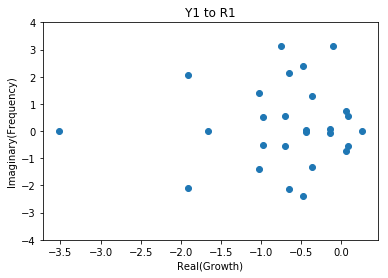

In [45]:
eiglog_Y1_R1=np.log(eig_values_Y1_R1)
plt.scatter(eiglog_Y1_R1.real,eiglog_Y1_R1.imag)
plt.title("Y1 to R1")
plt.ylim(-4,4)
plt.xlabel("Real(Growth)")
plt.ylabel("Imaginary(Frequency)")
plt.show()

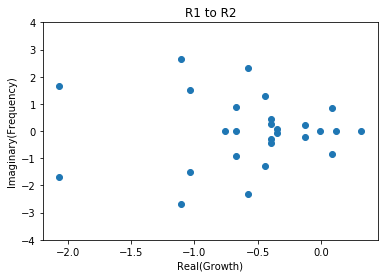

In [46]:
eiglog_R1_R2=np.log(eig_values_R1_R2)
plt.scatter(eiglog_R1_R2.real,eiglog_R1_R2.imag)
plt.title("R1 to R2")
plt.ylim(-4,4)
plt.xlabel("Real(Growth)")
plt.ylabel("Imaginary(Frequency)")
plt.show()

In [47]:
lamphi_Y1_R1=np.zeros(eiglog_Y1_R1.shape)

In [48]:
for i in range (27):
    rep=eig_vectors_Y1_R1[i]
    norm=np.linalg.norm(rep)
    val=np.absolute(eig_values_Y1_R1[i])*norm
    lamphi_Y1_R1[i]=val
lamphi_Y1_R1

array([2.21525778, 1.28676877, 1.30880753, 1.07541668, 0.85766685,
       1.08562366, 0.88446921, 0.60254226, 0.88308469, 0.63519709,
       0.83539271, 0.70412341, 0.45052276, 0.6430176 , 0.61914462,
       0.57964956, 0.61384224, 0.35122285, 0.28016582, 0.37906699,
       0.33362539, 0.08007995, 0.11110657, 0.21609951, 0.21270067,
       0.17117314, 0.01686412])

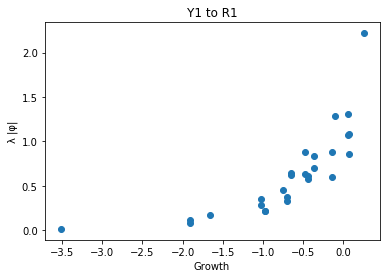

In [49]:
plt.scatter(eiglog_Y1_R1.real,lamphi_Y1_R1)
plt.title("Y1 to R1")
plt.xlabel("Growth")
plt.ylabel(u'\u03BB' ' |' u'\u03C6''|')
plt.show()

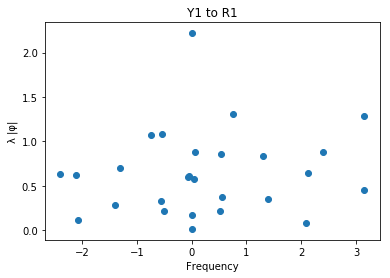

In [50]:
plt.scatter(eiglog_Y1_R1.imag,lamphi_Y1_R1)
plt.title("Y1 to R1")
plt.xlabel("Frequency")
plt.ylabel(u'\u03BB' ' |' u'\u03C6''|')
plt.show()

In [51]:
lamphi_R1_R2=np.zeros(27)

In [52]:
for i in range (27):
    rep=eig_vectors_R1_R2[i]
    norm=np.linalg.norm(rep)
    val=np.absolute(eig_values_R1_R2[i])*norm
    lamphi_R1_R2[i]=val
lamphi_R1_R2
    

array([0.95178545, 0.64058627, 1.02485701, 1.32791148, 1.38726038,
       0.36109822, 0.35286708, 0.68724874, 0.5421182 , 0.4758837 ,
       0.41320899, 0.13693727, 0.11543297, 0.40346378, 0.35597957,
       0.9229686 , 1.16071376, 1.04350085, 0.55857016, 0.55744498,
       0.72709652, 0.44089692, 0.36292593, 0.40056516, 0.58382245,
       0.45218019, 0.38459771])

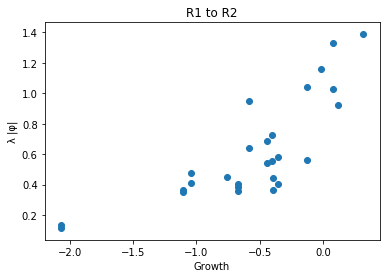

In [53]:
plt.scatter(eiglog_R1_R2.real,lamphi_R1_R2)
plt.title("R1 to R2")
plt.xlabel("Growth")
plt.ylabel(u'\u03BB' ' |' u'\u03C6''|')
plt.show()

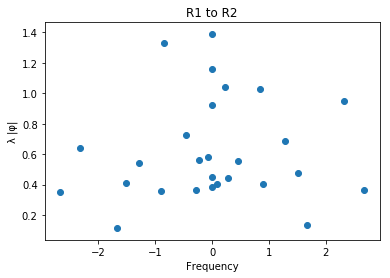

In [54]:
plt.scatter(eiglog_R1_R2.imag,lamphi_R1_R2)
plt.title("R1 to R2")
plt.xlabel("Frequency")
plt.ylabel(u'\u03BB' ' |' u'\u03C6''|')
plt.show()

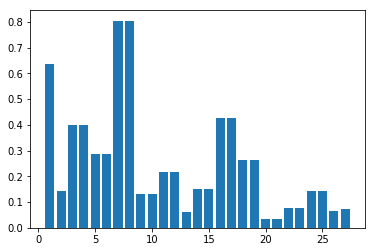

In [55]:
index=np.zeros(27)
weiabs=np.zeros(27)
for i in range (27):
    index[i]=i+1
for j in range (27):
    weiabs[j]=np.absolute(eig_vectors_Y1_R1[0,j])
plt.bar(index,weiabs)
plt.show()

In [60]:
eig_vectors_Y1_R1.shape
eig_values_Y1_R1

array([ 1.29007059+0.j        , -0.90140639+0.j        ,
        0.77908357+0.72741072j,  0.77908357-0.72741072j,
        0.92661067+0.55679651j,  0.92661067-0.55679651j,
        0.86743508+0.05140103j,  0.86743508-0.05140103j,
       -0.45531187+0.4204175j , -0.45531187-0.4204175j ,
        0.18086368+0.67040147j,  0.18086368-0.67040147j,
       -0.47176449+0.j        , -0.27272013+0.44583593j,
       -0.27272013-0.44583593j,  0.64440421+0.0270954j ,
        0.64440421-0.0270954j ,  0.06026113+0.3539383j ,
        0.06026113-0.3539383j ,  0.4226191 +0.26194216j,
        0.4226191 -0.26194216j, -0.07251408+0.12995056j,
       -0.07251408-0.12995056j,  0.32805226+0.18445628j,
        0.32805226-0.18445628j,  0.18947976+0.j        ,
        0.02962638+0.j        ])

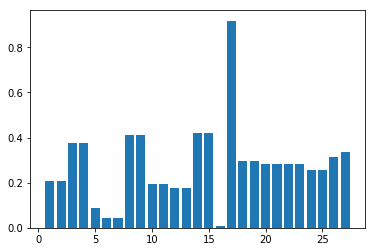

In [57]:
weiabs2=np.zeros(27)
for j in range (27):
    weiabs2[j]=np.absolute(eig_vectors_R1_R2[0,j])
plt.bar(index,weiabs2)
plt.show()